<a href="https://colab.research.google.com/github/ArashDehghanyan/ml-practicres/blob/main/YoloV2Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.8.0


In [39]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [40]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar

--2022-04-13 13:02:05--  http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1999639040 (1.9G) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2012.tar.2’

VOCtrainval_11-May- 100%[===================>]   1.86G  30.6MB/s    in 64s     

2022-04-13 13:03:10 (29.7 MB/s) - ‘VOCtrainval_11-May-2012.tar.2’ saved [1999639040/1999639040]



In [41]:
! tar xvf VOCtrainval_11-May-2012.tar

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

##Parse annotations from the XML files and store it in an array

In [42]:
import os
import xml.etree.ElementTree as ET


def parse_annotation(ann_dir, img_dir, labels=[]):
    all_img = []
    seen_labels = {}

    for ann in sorted(os.listdir(ann_dir)):
        if "xml" not in ann:
            continue

        img = {'object': []}

        tree = ET.parse(ann_dir + ann)
        for elem in tree.iter():
            if 'filename' in elem.tag:
                path_to_image = img_dir + elem.text
                img['filename'] = path_to_image
                # make sure that image exists
                if not os.path.exists(path_to_image):
                    assert False, "file does not exist\n{}".format(path_to_image)
            if 'width' in elem.tag:
                img['width'] = int(elem.text)
            if 'height' in elem.tag:
                img['height'] = int(elem.text)
            if 'object' in elem.tag or 'part' in elem.tag:
                obj = {}

                for attr in list(elem):
                    if 'name' in attr.tag:
                        obj['name'] = attr.text
                        if len(labels) > 0  and obj['name'] not in labels:
                            break
                        else:
                            img['object'] += [obj]

                        if obj['name'] in seen_labels:
                            seen_labels[obj['name']] += 1
                        else:
                            seen_labels[obj['name']] = 1
                        
                    if 'bndbox' in attr.tag:
                        for dim in list(attr):
                            if 'xmin' in dim.tag:
                                obj['xmin'] = int(round(float(dim.text)))
                            if 'ymin' in dim.tag:
                                obj['ymin'] = int(round(float(dim.text)))
                            if 'xmax' in dim.tag:
                                obj['xmax'] = int(round(float(dim.text)))
                            if 'ymax' in dim.tag:
                                obj['ymax'] = int(round(float(dim.text)))

        if len(img['object']) > 0:
            all_img += [img]

    return all_img, seen_labels

In [43]:
import numpy as np
# Parse annotation
train_image_folder = "VOCdevkit/VOC2012/JPEGImages/"
train_annot_folder = "VOCdevkit/VOC2012/Annotations/"

ANCHORS = np.array([
    1.07709888,  1.78171903,  # anchor box 1, width , height
    2.71054693,  5.12469308,  # anchor box 2, width,  height
    10.47181473, 10.09646365,  # anchor box 3, width,  height
    5.48531347,  8.11011331    # anchor box 4, width, height
])

LABELS = [
    'aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
    'bus',        'car',      'cat',  'chair',     'cow',
    'diningtable','dog',    'horse',  'motorbike', 'person',
    'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'
]

train_images, seen_train_labels = parse_annotation(
    train_annot_folder, train_image_folder, labels=LABELS)

print("train number: {}".format(len(train_images)))

train number: 17125


##Define a class to process an image

In [44]:
import copy
import cv2


class ImageReader(object):
    def __init__(self, image_h, image_w, norm=None):
        self.IMAGE_H = image_h
        self.IMAGE_W = image_w
        self.norm = norm

    def encode_core(self, image, reorder_rgb=True):
        image = cv2.resize(image, (self.IMAGE_H, self.IMAGE_W))

        if reorder_rgb:
            image = image[:, :, ::-1]
        
        if self.norm:
            image = self.norm(image)
        return image

    def fit(self, train_instance):
        if not isinstance(train_instance, dict):
            train_instance = {'filename': train_instance}
        
        img_name = train_instance['filename']
        image = cv2.imread(img_name)
        if image is None: print("Cannot find", img_name)
        h, w, c = image.shape

        image = self.encode_core(image, reorder_rgb=True)

        if "object" in train_instance.keys():

            all_objs = copy.deepcopy(train_instance['object'])
            for obj in all_objs:
                for attr in ['xmin', 'xmax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_W) / w)
                    obj[attr] = max(min(obj[attr], self.IMAGE_W), 0)

                for attr in ['ymin', 'ymax']:
                    obj[attr] = int(obj[attr] * float(self.IMAGE_H) / h)
                    obj[attr] = max(min(obj[attr], self.IMAGE_H), 0)
        else:
            return image
        return image, all_objs

###Sample usage of class "ImageReader"


******************************
Input
    object: [{'name': 'person', 'xmin': 174, 'ymin': 101, 'xmax': 349, 'ymax': 351}]
    filename: VOCdevkit/VOC2012/JPEGImages/2007_000027.jpg
    width: 486
    height: 500
******************************
Output
        [{'name': 'person', 'xmin': 148, 'ymin': 84, 'xmax': 298, 'ymax': 292}]


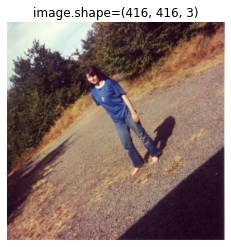

In [45]:
def normalize(image): 
    return image / 255.

print("*"*30)
print("Input")

sample = train_images[0]
for k, v in sample.items():
    print("    {}: {}".format(k, v))
print("*"*30)
print("Output")
inputEncoder = ImageReader(image_h=416, image_w=416, norm=normalize)
image, all_objects = inputEncoder.fit(sample)
print("        {}".format(all_objects))
plt.imshow(image)
plt.title("image.shape={}".format(image.shape))
plt.axis('off')
plt.show()

###Define Best Anchor box finder

In [46]:
class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, confidence=None, 
                 classes=None):
        self.xmin, self.ymin = xmin, ymin
        self.xmax, self.ymax = xmax, ymax

        self.confidence = confidence
        self.set_class(classes)

    def set_class(self, classes):
        self.classes = classes
        self.label = np.argmax(self.classes)

    def get_label(self):
        return self.label

    def get_score(self):
        return self.classes[self.label]


class BestAnchorBoxFinder(object):
    def __init__(self, ANCHORS):
        """
        ANCHORS:  a np.array of even number length e.g.

        _ANCHORS = [
            4, 2, ##width=4, height=2, flat large anchor box
            2, 4, ##width=2, height=4, tall large box
            1, 1, ##width=1, height=1, small anchor box
        ]
        """
        self.anchors = [BoundBox(0, 0, ANCHORS[2*i], ANCHORS[2*i+1]) 
                        for i in range(int(len(ANCHORS) // 2))]
        
    def _interval_overlap(self, interval_a, interval_b):
        x1, x2 = interval_a
        x3, x4 = interval_b
        return max(min(x2, x4) - max(x1, x3), 0)
    
    def intersect_over_union(self, box1, box2):
        intersect_w = self._interval_overlap([box1.xmin, box1.xmax], 
                                             [box2.xmin, box2.xmax])
        intersesect_h = self._interval_overlap([box1.ymin, box1.ymax],
                                               [box2.ymin, box2.ymax])
        intersect_area = intersect_w * intersesect_h

        w1, h1 = box1.xmax - box1.xmin, box1.ymax - box1.ymin
        w2, h2 = box2.xmax - box2.xmin, box2.ymax - box2.ymin

        union_area = w1 * h1 + w2 * h2 - intersect_area + 1e-6
        return float(intersect_area) / union_area
    
    def find(self, center_w, center_h):
        # Find anchor that best predicts this box
        best_anchor = -1
        max_iou = -1

        shifted_box = BoundBox(0, 0, center_w, center_h)
        # For given object find the best box
        for i in range(len(self.anchors)):
            anchor = self.anchors[i]
            iou = self.intersect_over_union(shifted_box, anchor)
            if max_iou < iou:
                best_anchor = i
                max_iou = iou
        
        return best_anchor, max_iou


###Sample usage of BestAnchorBoxFinder class

In [47]:
_ANCHORS01 = np.array([0.08285376, 0.13705531,
                       0.20850361, 0.39420716,
                       0.80552421, 0.77665105,
                       0.42194719, 0.62385487])

print(",,"*40)
print("The three example anchor boxes:")
count = 0
for i in range(0, len(_ANCHORS01), 2):
    print("anchor box index={}, w={}, h={}".format(count, _ANCHORS01[i], _ANCHORS01[i+1]))
    count += 1

print(",,"*40)
print("Allocate bounding box of various width and height into the three anchor boxes:")
babf = BestAnchorBoxFinder(_ANCHORS01)
for w in range(1, 9, 2):
    w /= 10.
    for h in range(1, 9, 2):
        h /= 10.
        best_anchor, max_iou = babf.find(w, h)
        print("Bounding box (w = {}, h = {}) --> best  anchor box = {}, iou = {:3.2f}".format(
            w, h, best_anchor, max_iou
        ))

,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
The three example anchor boxes:
anchor box index=0, w=0.08285376, h=0.13705531
anchor box index=1, w=0.20850361, h=0.39420716
anchor box index=2, w=0.80552421, h=0.77665105
anchor box index=3, w=0.42194719, h=0.62385487
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Allocate bounding box of various width and height into the three anchor boxes:
Bounding box (w = 0.1, h = 0.1) --> best  anchor box = 0, iou = 0.63
Bounding box (w = 0.1, h = 0.3) --> best  anchor box = 0, iou = 0.38
Bounding box (w = 0.1, h = 0.5) --> best  anchor box = 1, iou = 0.42
Bounding box (w = 0.1, h = 0.7) --> best  anchor box = 1, iou = 0.35
Bounding box (w = 0.3, h = 0.1) --> best  anchor box = 0, iou = 0.25
Bounding box (w = 0.3, h = 0.3) --> best  anchor box = 1, iou = 0.57
Bounding box (w = 0.3, h = 0.5) --> best  anchor box = 3, iou = 0.57
Bounding box (w = 0.3, h = 0.7) --> best  anchor box = 3

In [48]:
def rescale_centerxy(obj, config):
    """
    obj:    a dictionary containing xmin, xmax, ymin, ymax
    config: a dictionary containing IMAGE_W, GIRD_W, IMAGE_H, GRID_H
    """
    center_x = 0.5 * (obj['xmin'] + obj['xmax'])
    center_x = center_x / (float(config['IMAGE_W']) / config['GRID_W'])
    center_y = 0.5 * (obj['ymin'] + obj['ymax'])
    center_y = center_y / (float(config['IMAGE_H']) / config['GRID_H'])
    return center_x, center_y

def rescale_centerwh(obj, config):
    """
    obj:    a dictionary containing xmin, xmax, ymin, ymax
    config: a dictionary containing IMAGE_W, GIRD_W, IMAGE_H, GRID_H
    """
    # unit grid cell
    center_w = (obj['xmax'] - obj['xmin']) / (float(config['IMAGE_W']) / config['GRID_W'])
    center_h = (obj['ymax'] - obj['ymin']) / (float(config['IMAGE_H']) / config['GRID_H'])

    return center_w, center_h

In [49]:
obj    = {'xmin': 150, 'ymin': 84, 'xmax': 300, 'ymax': 294}
config = {"IMAGE_W":416,"IMAGE_H":416,"GRID_W":13,"GRID_H":13}

center_x, center_y = rescale_centerxy(obj, config)
center_w, center_h = rescale_centerwh(obj, config)

print("cebter_x abd cebter_w should range between 0 and {}".format(config["GRID_W"]))
print("cebter_y abd cebter_h should range between 0 and {}".format(config["GRID_H"]))

print("center_x = {:06.3f} range between 0 and {}".format(center_x, config["GRID_W"]))
print("center_y = {:06.3f} range between 0 and {}".format(center_y, config["GRID_H"]))
print("center_w = {:06.3f} range between 0 and {}".format(center_w, config["GRID_W"]))
print("center_h = {:06.3f} range between 0 and {}".format(center_h, config["GRID_H"]))

cebter_x abd cebter_w should range between 0 and 13
cebter_y abd cebter_h should range between 0 and 13
center_x = 07.031 range between 0 and 13
center_y = 05.906 range between 0 and 13
center_w = 04.688 range between 0 and 13
center_h = 06.562 range between 0 and 13


##Define a custom Batch generator

In [50]:
from tensorflow.keras.utils import Sequence

class SimpleBatchGenerator(Sequence):
    def __init__(self, images, config, norm=None, shuffle=True):
        """
        Config:     a dict containing hyper parameters for training e.g.
            {
                'IMAGE_W'     :416,
                'IMAGE_H'     :426, 
                'GRID_W'      :13,
                'GRID_H'      :13,
                'LABELS'      :[
                    'aeroplane',  'bicycle', 'bird',  'boat',      'bottle', 
                    'bus',        'car',      'cat',  'chair',     'cow',
                    'diningtable','dog',    'horse',  'motorbike', 'person',
                    'pottedplant','sheep',  'sofa',   'train',   'tvmonitor'
                ], 
                'ANCHORS'       : array([
                    1.07709888,   1.78171903,  
                    2.71054693,   5.12469308, 
                    10.47181473, 10.09646365,  
                    5.48531347,   8.11011331
                ]), 
                BATCH_SIZE      : 16,
                TRUE_BOX_BUFFER: 50
            }
            """

        self.config = config
        self.config['BOX'] = int(len(self.config['ANCHORS']) / 2)
        self.config['CLASS'] = len(self.config['LABELS'])
        self.images = images
        self.bestAnchorBoxFinder = BestAnchorBoxFinder(self.config['ANCHORS'])
        self.image_reader = ImageReader(self.config['IMAGE_H'], 
                                        self.config['IMAGE_W'], norm=norm)
        self.shuffle = shuffle
        if self.shuffle:
            np.random.shuffle(self.images)

    def __len__(self):
        return int(np.ceil(float(len(self.images)) / self.config['BATCH_SIZE']))
    
    def __getitem__(self, idx):
        '''
        ===input===

        idx : non-negative integer value

        ==output==

        x_batch: The numpy array of shape (BATCH_SIZE, IMAGE_H, IMAGE_W, N CHANNELS)

        y_btach: The numpy array of shape (BATCH_SIZE, GRID_H, GRID_W, BOX, 4+1+N CHANNELS)

        BOX = The number of Anchor box

        b_batch: The numpy array of shape (batch_size, 1, 1, 1, TRUE_BOX_BUFFER, 4)
        '''
        l_bound = idx * self.config['BATCH_SIZE']
        r_bound = (idx + 1) * self.config['BATCH_SIZE']

        if r_bound > len(self.images):
            r_bound = len(self.images)
            l_bound = r_bound - self.config['BATCH_SIZE']

        instance_count = 0

        # prepare empty storage space
        x_batch = np.zeros((r_bound - l_bound, self.config['IMAGE_H'], 
                            self.config['IMAGE_W'], 3))
        b_batch = np.zeros((r_bound - l_bound, 1, 1, 1, 
                            self.config['TRUE_BOX_BUFFER'], 4))
        # desired network output
        y_batch = np.zeros((r_bound - l_bound, self.config['GRID_H'], 
                            self.config['GRID_W'], self.config['BOX'], 
                            4+1+len(self.config['LABELS'])))
        
        for train_instance in self.images[l_bound:r_bound]:
            # augment input image and fix object's position and size
            img, all_objs = self.image_reader.fit(train_instance)
            # constructs output from object's x, y, w, h
            true_box_index = 0

            for obj in all_objs:
                if obj['xmax'] > obj['xmin'] and obj['ymax'] > obj['ymin'] and obj['name'] in self.config['LABELS']:
                    center_x, center_y = rescale_centerxy(obj, self.config)

                    grid_x = int(np.floor(center_x))
                    grid_y = int(np.floor(center_y))

                    if grid_x < self.config['GRID_W'] and grid_y < self.config['GRID_H']:
                        obj_idx = self.config['LABELS'].index(obj['name'])
                        center_w, center_h = rescale_centerwh(obj, self.config)
                        box = [center_x, center_y, center_w, center_h]
                        best_anchor, max_iou = self.bestAnchorBoxFinder.find(center_w, center_h)

                        y_batch[instance_count, grid_y, grid_x, best_anchor, 0:4] = box 
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 4] = 1.     # ground truth confidence is 1
                        y_batch[instance_count, grid_y, grid_x, best_anchor, 5+obj_idx] = 1 # class probability of the object

                        # assign true_box_index to b_batch
                        b_batch[instance_count, 0, 0, 0, true_box_index] = box
                        true_box_index += 1
                        true_box_index = true_box_index % self.config['TRUE_BOX_BUFFER']
            
            x_batch[instance_count] = img
            instance_count += 1
        return [x_batch, b_batch], y_batch

    def on_epoch_end(self):
        if self.shuffle:
            return np.random.shuffle(self.images)

In [51]:
GRID_H,  GRID_W  = 13 , 13
ANCHORS          = _ANCHORS01
ANCHORS[::2]     = ANCHORS[::2]*GRID_W  
ANCHORS[1::2]    = ANCHORS[1::2]*GRID_H  
ANCHORS

array([ 1.07709888,  1.78171903,  2.71054693,  5.12469308, 10.47181473,
       10.09646365,  5.48531347,  8.11011331])

In [52]:
IMAGE_H, IMAGE_W = 416, 416
BATCH_SIZE       = 16
TRUE_BOX_BUFFER  = 50
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)

generator_config = {
    'IMAGE_H'         : IMAGE_H, 
    'IMAGE_W'         : IMAGE_W,
    'GRID_H'          : GRID_H,  
    'GRID_W'          : GRID_W,
    'BOX'             : BOX,
    'LABELS'          : LABELS,
    'ANCHORS'         : ANCHORS,
    'BATCH_SIZE'      : BATCH_SIZE,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
}

train_batch_generator = SimpleBatchGenerator(train_images, generator_config, 
                                             norm=normalize, shuffle=True)

[x_batch, b_batch], y_batch = train_batch_generator.__getitem__(idx=1)

print("x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = {}".format(x_batch.shape))
print("y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = {}".format(y_batch.shape))
print("b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = {}".format(b_batch.shape))


x_batch: (BATCH_SIZE, IMAGE_H, IMAGE_W, N channels)           = (16, 416, 416, 3)
y_batch: (BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + N classes) = (16, 13, 13, 4, 25)
b_batch: (BATCH_SIZE, 1, 1, 1, TRUE_BOX_BUFFER, 4)            = (16, 1, 1, 1, 50, 4)


In [53]:
iframe = 3

def check_object_in_grid_anchor_pair(irow):
    for igrid_h in range(generator_config["GRID_H"]):
        for igrid_w in range(generator_config["GRID_W"]):
            for ianchor in range(generator_config["BOX"]):
                vec = y_batch[irow, igrid_h, igrid_w, ianchor, :]
                C = vec[4]   # ground truth confidence
                if C == 1:
                    class_nm = np.array(LABELS)[np.where(vec[5:])]
                    assert len(class_nm) == 1
                    print("igrid_h={:02.0f}, igrid_w={:02.0f}, iAnchor={:02.0f}, {}".format(
                        igrid_h, igrid_w, ianchor, class_nm[0]
                    ))

check_object_in_grid_anchor_pair(iframe)

igrid_h=07, igrid_w=06, iAnchor=01, person


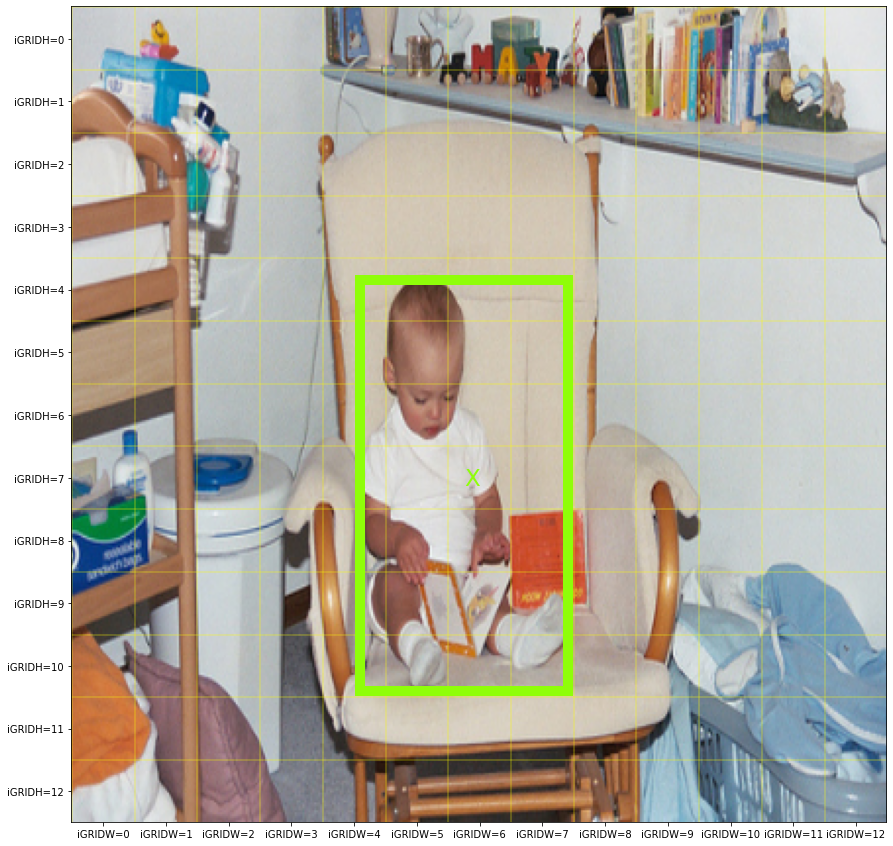

In [54]:
def plot_image_with_grid_cell_partition(irow):
    img = x_batch[irow]
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    # plot grid on image
    for wh in ["W", "H"]:
        GRID_ = generator_config["GRID_" + wh]  # 13
        IMAGE_ = generator_config["IMAGE_" + wh]    # 416
        if wh == "W":
            pltax = plt.axvline     # plot vertical lines on X axis
            plttick = plt.xticks
        else:
            pltax = plt.axhline     # plot horizontal lines on y axis
            plttick  = plt.yticks
        
        for count in range(GRID_):
             # plot grid lines
            pltax(IMAGE_*count/GRID_, color='yellow', alpha=0.3)
        # set x & y ticks
        plttick([IMAGE_*(i+0.5)/GRID_ for i in range(GRID_)], 
                ["iGRID{}={}".format(wh, i) for i in range(GRID_)])


def plot_grid(irow):
    import seaborn as sns
    color_palette = list(sns.xkcd_rgb.values())
    iobj = 0
    for igrid_h in range(generator_config['GRID_H']):
        for igrid_w in range(generator_config['GRID_W']):
            for ianchor in range(generator_config['BOX']):
                vec = y_batch[irow, igrid_h, igrid_w, ianchor, :]
                confidence = vec[4] # ground truth confidence
                if confidence == 1:
                    class_name = np.array(LABELS)[np.where(vec[5:])]
                    x, y, w, h = vec[:4]
                    multx = generator_config['IMAGE_W'] \
                    / generator_config['GRID_W']
                    multy = generator_config['IMAGE_H'] \
                    / generator_config['GRID_H']
                    c = color_palette[iobj]
                    iobj += 1
                    xmin = x - 0.5 * w
                    xmax = x + 0.5 * w
                    ymin = y - 0.5 * h
                    ymax = y + 0.5 * h
                    # plot center
                    plt.text(x*multx, y*multy, "X", color=c, fontsize=23)
                    # plot rectangle around object
                    plt.plot(np.array([xmin, xmin])*multx, 
                             np.array([ymin, ymax])*multy, 
                             color=c, linewidth=10)
                    plt.plot(np.array([xmin, xmax])*multx, 
                             np.array([ymin, ymin])*multy, color=c, 
                             linewidth=10)
                    plt.plot(np.array([xmax, xmax])*multx, 
                             np.array([ymin, ymax])*multy, color=c, 
                             linewidth=10)
                    plt.plot(np.array([xmin, xmax])*multx,
                             np.array([ymax, ymax])*multy, color=c, 
                             linewidth=10)

plot_image_with_grid_cell_partition(iframe)
plot_grid(iframe)
plt.show()

----------------------------------------
igrid_h=06, igrid_w=06, iAnchor=02, bus


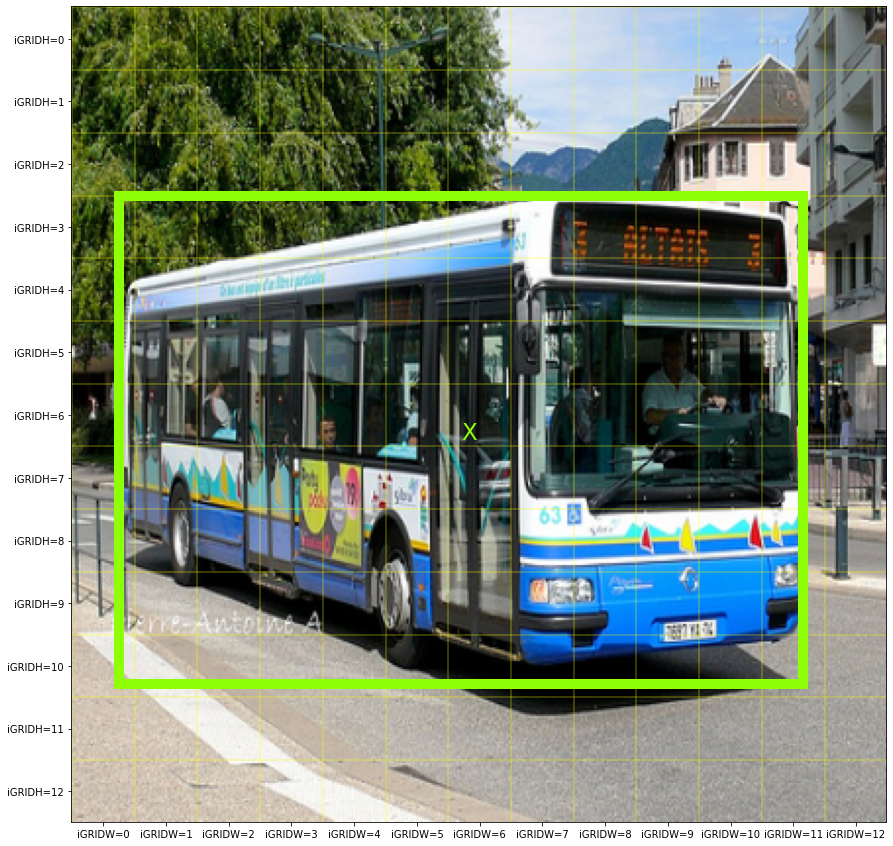

----------------------------------------
igrid_h=06, igrid_w=06, iAnchor=02, pottedplant


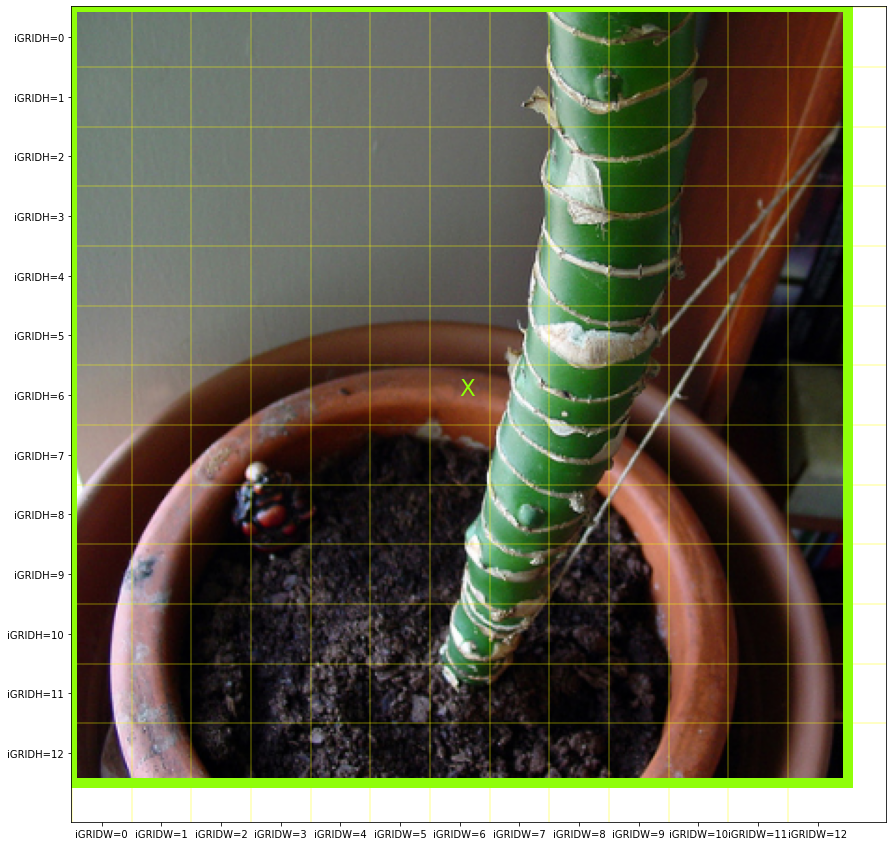

----------------------------------------
igrid_h=08, igrid_w=06, iAnchor=01, person


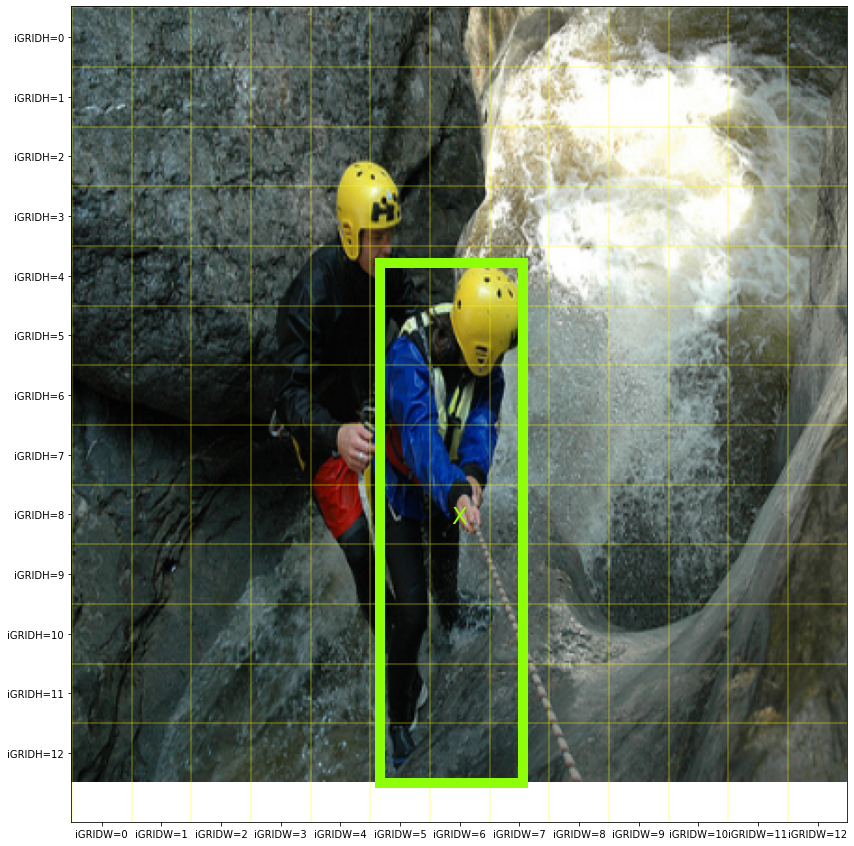

----------------------------------------
igrid_h=06, igrid_w=08, iAnchor=02, person


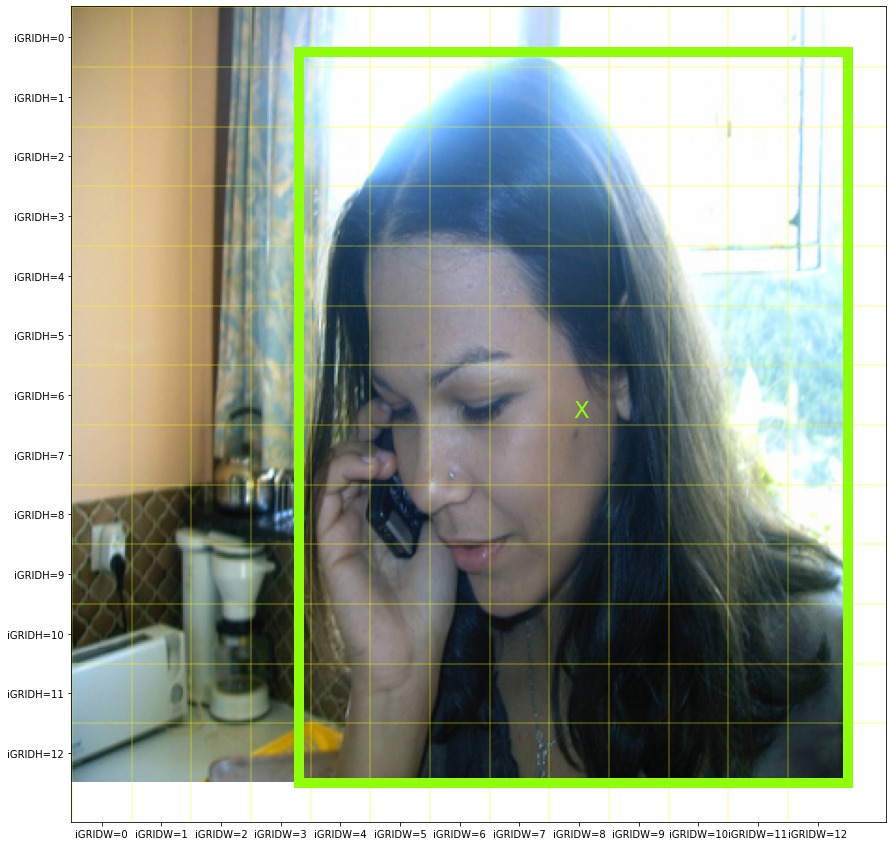

----------------------------------------
igrid_h=04, igrid_w=05, iAnchor=02, aeroplane


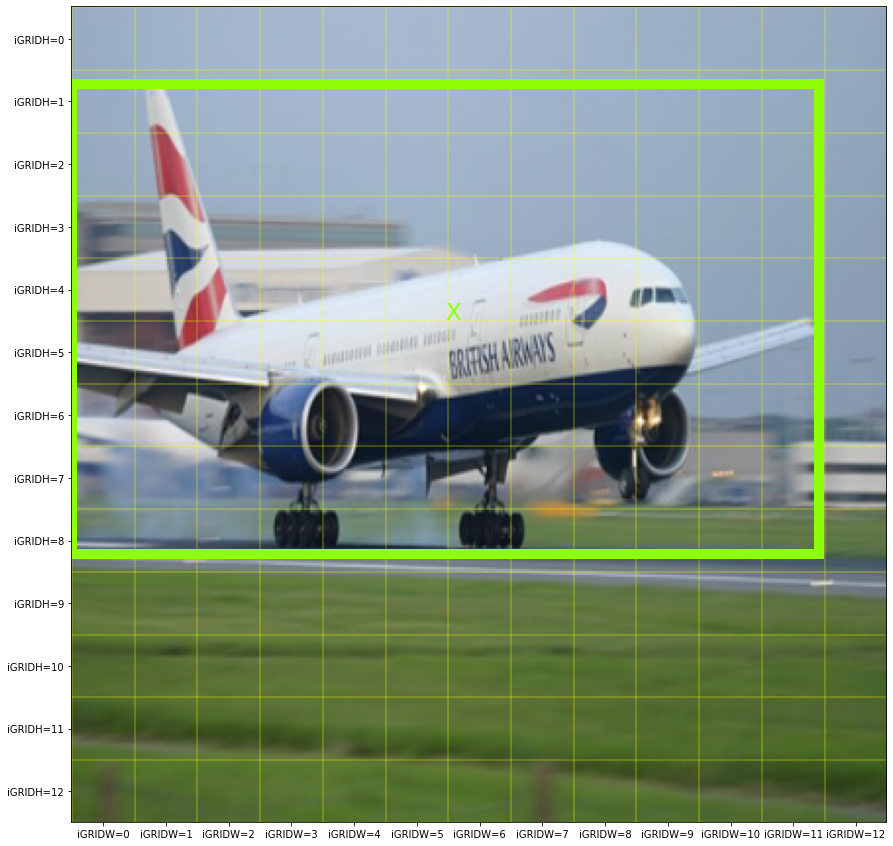

In [55]:
for irow in range(5, 10):
    print("-"*40)
    check_object_in_grid_anchor_pair(irow)
    plot_image_with_grid_cell_partition(irow)
    plot_grid(irow)
    plt.show()

In [56]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Reshape, Activation, Conv2D, BatchNormalization, LeakyReLU, MaxPooling2D, Dense, Lambda, Flatten, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import tensorflow.keras.backend as k
import tensorflow as tf

# the function to implement the orgnization layer (thanks to github.com/allanzelener/YAD2K)
def space_to_depth_x2(x):
    return tf.nn.space_to_depth(x, block_size=2)

# Define Darknet layers
# Input layers
input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
input_true_boxes = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER, 4))

# Layer 1
x = Conv2D(32, (3,3), strides=(1,1), padding='same', name='conv_1', use_bias=False)(input_image)
x = BatchNormalization(name='norm_1')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Layer 2
x = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv_2', use_bias=False)(x)
x = BatchNormalization(name='norm_2')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Layer 3
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_3', use_bias=False)(x)
x = BatchNormalization(name='norm_3')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 4
x = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_4', use_bias=False)(x)
x = BatchNormalization(name='norm_4')(x)
x = LeakyReLU(alpha=0.1)(x)


# Layer 5
x = Conv2D(128, (3,3), strides=(1,1), padding='same', name='conv_5', use_bias=False)(x)
x = BatchNormalization(name='norm_5')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Layer 6
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_6', use_bias=False)(x)
x = BatchNormalization(name='norm_6')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 7
x = Conv2D(128, (1,1), strides=(1,1), padding='same', name='conv_7', use_bias=False)(x)
x = BatchNormalization(name='norm_7')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 8
x = Conv2D(256, (3,3), strides=(1,1), padding='same', name='conv_8', use_bias=False)(x)
x = BatchNormalization(name='norm_8')(x)
x = LeakyReLU(alpha=0.1)(x)
x = MaxPooling2D(pool_size=(2,2))(x)

# Layer 9
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_9', use_bias=False)(x)
x = BatchNormalization(name='norm_9')(x)
x = LeakyReLU(alpha=0.1)(x)


# Layer 10
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_10', use_bias=False)(x)
x = BatchNormalization(name='norm_10')(x)
x = LeakyReLU(alpha=0.1)(x)


# Layer 11
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_11', use_bias=False)(x)
x = BatchNormalization(name='norm_11')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 12
x = Conv2D(256, (1,1), strides=(1,1), padding='same', name='conv_12', use_bias=False)(x)
x = BatchNormalization(name='norm_12')(x)
x = LeakyReLU(alpha=0.1)(x)


# Layer 13
x = Conv2D(512, (3,3), strides=(1,1), padding='same', name='conv_13', use_bias=False)(x)
x = BatchNormalization(name='norm_13')(x)
x = LeakyReLU(alpha=0.1)(x)

skip_connection = x

x = MaxPooling2D(pool_size=(2,2))(x)

# Layer 14
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_14', use_bias=False)(x)
x = BatchNormalization(name='norm_14')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 15
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_15', use_bias=False)(x)
x = BatchNormalization(name='norm_15')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 16
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_16', use_bias=False)(x)
x = BatchNormalization(name='norm_16')(x)
x = LeakyReLU(alpha=0.1)(x)


# Layer 17
x = Conv2D(512, (1,1), strides=(1,1), padding='same', name='conv_17', use_bias=False)(x)
x = BatchNormalization(name='norm_17')(x)
x = LeakyReLU(alpha=0.1)(x)


# Layer 18
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_18', use_bias=False)(x)
x = BatchNormalization(name='norm_18')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 19
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_19', use_bias=False)(x)
x = BatchNormalization(name='norm_19')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 20
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_20', use_bias=False)(x)
x = BatchNormalization(name='norm_20')(x)
x = LeakyReLU(alpha=0.1)(x)

# Layer 21
skip_connection = Conv2D(64, (1,1), strides=(1,1), padding='same', name='conv_21', use_bias=False)(skip_connection)
skip_connection = BatchNormalization(name='norm_21')(skip_connection)
skip_connection = LeakyReLU(alpha=0.1)(skip_connection)
skip_connection = Lambda(space_to_depth_x2)(skip_connection)

x = concatenate([skip_connection, x])

# Layer 22
x = Conv2D(1024, (3,3), strides=(1,1), padding='same', name='conv_22', use_bias=False)(x)
x = BatchNormalization(name='norm_22')(x)
x = LeakyReLU(alpha=0.1)(x)


# Layer 23
x = Conv2D(BOX*(4 + 1 + CLASS), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
output = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS))(x)

# small hack to allow true_boxes to be registered when Keras build the model 
# for more information: https://github.com/fchollet/keras/issues/2790
output = Lambda(lambda args: args[0])([output, input_true_boxes])

yolo = Model([input_image, input_true_boxes], output)
yolo.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_1 (Conv2D)                (None, 416, 416, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 norm_1 (BatchNormalization)    (None, 416, 416, 32  128         ['conv_1[0][0]']                 
                                )                                                             

#Download pre trained weights for Yolo V2

In [57]:
! wget https://pjreddie.com/media/files/yolov2.weights

--2022-04-13 13:03:40--  https://pjreddie.com/media/files/yolov2.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203934260 (194M) [application/octet-stream]
Saving to: ‘yolov2.weights’

yolov2.weights      100%[===================>] 194.49M  40.3MB/s    in 5.2s    

2022-04-13 13:03:45 (37.1 MB/s) - ‘yolov2.weights’ saved [203934260/203934260]



In [58]:
path_to_weight = "./yolov2.weights"

class WeightReader:

    def __init__(self, weight_file):
        self.offset = 4
        self.all_weights = np.fromfile(weight_file, dtype='float32')

    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]

    def reset(self):
        self.offset = 4

weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

all_weights.shape = (50983565,)


In [59]:
weight_reader.reset()
conv_number = 23

for i in range(1, conv_number + 1):
    conv_layer = yolo.get_layer('conv_' + str(i))

    if i < conv_number:
        norm_layer = yolo.get_layer('norm_' + str(i))
        size = np.prod(norm_layer.get_weights()[0].shape)
        
        beta = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean = weight_reader.read_bytes(size)
        var = weight_reader.read_bytes(size)
        weights = norm_layer.set_weights([gamma, beta, mean, var])
    
    if len(conv_layer.get_weights()) > 1:
        bias = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2, 3, 1, 0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2, 3, 1, 0])
        conv_layer.set_weights([kernel])


In [60]:
layer = yolo.layers[-4] # the last convolutional layer
weights = layer.get_weights()
print(weights[0].shape)
new_kernel = np.random.normal(size=weights[0].shape) / (GRID_H * GRID_W)
new_bias = np.random.normal(size=weights[1].shape) / (GRID_H * GRID_W)
layer.set_weights([new_kernel, new_bias])

(1, 1, 1024, 100)


#Custom learning rate scheduler

In [61]:
from tensorflow import keras


class CustomLearningRateScheduler(keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate
        lr = float(keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule to get scheduled learning rate
        scheduled_lr = self.schedule(epoch, lr)
        keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]

def lr_schedule(epoch, lr):
    """Helper function to retrieve scheduled learning rate."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    
    for item in LR_SCHEDULE:
        if epoch == item[0]:
            return item[1]
    return lr

In [62]:
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
LAMBDA_CLASS     = 1.0

In [63]:
def get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX):
    '''
        Helper function to assure that the bounding box x and y are in the grid cell scale
        '''
    # cell_x.shape = (1, 13, 13, 1, 1)
    cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)
    # cell_y.shape = (1, 13, 13, 1, 1)
    cell_y = tf.transpose(cell_x, (0, 2, 1, 3, 4))
    # cell_grid.shape = (16, 13, 13, 5, 2)
    cell_grid = tf.tile(tf.concat([cell_x, cell_y], -1), [BATCH_SIZE, 1, 1, BOX, 1])
    return cell_grid
get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX).shape

TensorShape([16, 13, 13, 4, 2])

In [64]:
def adjust_scale_predictions(y_pred, cell_grid, ANCHORS):
    '''
    Adjust prediction
    '''
    BOX = int(len(ANCHORS)/2)

    pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid   #bx, by
    pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS, [1, 1, 1, BOX, 2])
    pred_box_conf = tf.sigmoid(y_pred[..., 4])
    # adjust class probabilities 
    pred_box_class = y_pred[..., 5:]
    return (pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class)
    

In [65]:
def print_min_max(vec, title):
    try:
        print("{} min={:5.2f}, max={:5.2f}".format(
            title, np.min(vec), np.max(vec)
        ))
    except ValueError:
        pass
        

In [71]:
print("*"*30)
print("Prepare inputs")
GRID_W = 13
GRID_H = 13
BOX = int(len(ANCHORS)/2)
CLASS = len(LABELS)
size = BATCH_SIZE * GRID_W * GRID_H * BOX * (4 + 1 + CLASS)
y_pred = np.random.normal(size=size, scale=10/(GRID_W*GRID_H))
y_pred = y_pred.reshape(BATCH_SIZE, GRID_H, GRID_W, BOX, 4 + 1 + CLASS)
print("y_prd before scaling = {}".format(y_pred.shape))

print("*"*30)
print("define tensor graph.")
y_pred_tf = tf.constant(y_pred, dtype='float32')
cell_grid = get_cell_grid(GRID_W, GRID_H, BATCH_SIZE, BOX)
(pred_box_xy, pred_box_wh, pred_box_conf, pred_box_class) = adjust_scale_predictions(y_pred_tf, cell_grid, ANCHORS)
print("*"*30 + "\nouput\n" + "*"*30) 
print("\npred_box_xy = {}".format(pred_box_xy.shape))

for igrid_w in range(pred_box_xy.shape[2]):
    print_min_max(
        pred_box_xy[:, :, igrid_w, :, 0], 
        " bounding box x at iGRID_W={:06.2f}".format(igrid_w)
    )

for igrid_h in range(pred_box_xy.shape[1]):
    print_min_max(
        pred_box_xy[:, igrid_h, :, :, 1],
        " bounding box y at iGRID_H={:06.2f}".format(igrid_h)
    )

print("\npred_box_wh {}".format(pred_box_wh.shape))
print_min_max(pred_box_wh[:,:,:,:,0], "  bounding box width ")
print_min_max(pred_box_wh[:,:,:,:,1], "  bounding box height")
print("\npred_box_conf {}".format(pred_box_conf.shape))
print_min_max(pred_box_conf, " confidence ")
print("\npred_box_class {}".format(pred_box_class.shape))
print_min_max(pred_box_class, " class probability")

******************************
Prepare inputs
y_prd before scaling = (16, 13, 13, 4, 25)
******************************
define tensor graph.
******************************
ouput
******************************

pred_box_xy = (16, 13, 13, 4, 2)
 bounding box x at iGRID_W=000.00 min= 0.44, max= 0.55
 bounding box x at iGRID_W=001.00 min= 1.46, max= 1.54
 bounding box x at iGRID_W=002.00 min= 2.45, max= 2.54
 bounding box x at iGRID_W=003.00 min= 3.45, max= 3.54
 bounding box x at iGRID_W=004.00 min= 4.44, max= 4.56
 bounding box x at iGRID_W=005.00 min= 5.46, max= 5.54
 bounding box x at iGRID_W=006.00 min= 6.45, max= 6.54
 bounding box x at iGRID_W=007.00 min= 7.45, max= 7.55
 bounding box x at iGRID_W=008.00 min= 8.46, max= 8.55
 bounding box x at iGRID_W=009.00 min= 9.46, max= 9.55
 bounding box x at iGRID_W=010.00 min=10.46, max=10.56
 bounding box x at iGRID_W=011.00 min=11.45, max=11.55
 bounding box x at iGRID_W=012.00 min=12.44, max=12.56
 bounding box y at iGRID_H=000.00 min= 0.4

#Extract Ground truth

In [73]:
def extract_ground_truth(y_true):
    true_box_xy = y_true[..., :2] # bounding box x, y coordinate in grid cell scale 
    true_box_wh = y_true[..., 2:4]# number of cells accross, horizontally and vertically
    true_box_conf = y_true[..., 4] # confidence
    true_box_class = tf.argmax(y_true[..., 5:], -1)
    return (true_box_xy, true_box_wh, true_box_conf, true_box_class)

In [82]:
print("Input y_batch = {}".format(y_batch.shape))

y_batch_tf = tf.constant(y_batch, dtype='float32')
(true_box_xy, true_box_wh,
 true_box_conf, true_box_class) = extract_ground_truth(y_batch_tf)
 
print("*"*30 + "\noutput\n" + "*"*30)
print("\ntrue_box_xy = {}".format(true_box_xy.shape))

for igrid_w in range(true_box_xy.shape[2]):
    vec = true_box_xy[:,:, igrid_w, :, 0]
    pick = true_box_conf[:,:,igrid_w,:] == 1
    print_min_max(vec[pick], 
                  " bounding box x at iGRID_W={:02.0f}".format(igrid_w))
    
for igrid_h in range(true_box_xy.shape[1]):
    vec = true_box_xy[:, igrid_h, :, :, 1]
    pick = true_box_conf[:, igrid_h, :, :] == 1
    print_min_max(vec[pick],
                  " bounding box y at iGRID_H={:02.0f}".format(igrid_h))

print("\ntrue_box_wh = {}".format(true_box_wh.shape))
print_min_max(true_box_xy[:,:,:,:,0], " bounding box width ")
print_min_max(true_box_xy[:,:,:,:,1], " bounding box height")

print("\ntrue_box_conf {}".format(true_box_conf.shape))
print("   confidence unique value = {}".format(np.unique(true_box_conf)))

print("\ntrue_box_class = {}".format(true_box_class.shape))
print("  class index, unique value = {}".format(np.unique(true_box_class)))

Input y_batch = (16, 13, 13, 4, 25)
******************************
output
******************************

true_box_xy = (16, 13, 13, 4, 2)
 bounding box x at iGRID_W=00 min= 0.36, max= 0.36
 bounding box x at iGRID_W=01 min= 1.81, max= 1.81
 bounding box x at iGRID_W=02 min= 2.23, max= 2.23
 bounding box x at iGRID_W=03 min= 3.38, max= 3.59
 bounding box x at iGRID_W=04 min= 4.78, max= 4.97
 bounding box x at iGRID_W=05 min= 5.17, max= 5.95
 bounding box x at iGRID_W=06 min= 6.20, max= 6.75
 bounding box x at iGRID_W=07 min= 7.17, max= 7.55
 bounding box x at iGRID_W=08 min= 8.00, max= 8.41
 bounding box x at iGRID_W=09 min= 9.06, max= 9.06
 bounding box x at iGRID_W=11 min=11.02, max=11.91
 bounding box y at iGRID_H=01 min= 1.77, max= 1.86
 bounding box y at iGRID_H=02 min= 2.30, max= 2.75
 bounding box y at iGRID_H=04 min= 4.97, max= 4.97
 bounding box y at iGRID_H=05 min= 5.03, max= 5.48
 bounding box y at iGRID_H=06 min= 6.50, max= 6.89
 bounding box y at iGRID_H=07 min= 7.05, max=

In [89]:
def calc_loss_xywh(true_box_conf, COORD_SCALE, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh):
    coord_mask = tf.expand_dims(true_box_conf, axis=-1) * COORD_SCALE
    number_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))

    loss_xy = tf.reduce_sum(tf.square(true_box_xy - pred_box_xy) * coord_mask) / (number_coord_box + 1e-6) / 2.
    loss_wh = tf.reduce_sum(tf.square(true_box_wh - pred_box_wh) * coord_mask) / (number_coord_box + 1e-6) / 2.
    return (loss_xy + loss_wh, coord_mask)

In [92]:
LAMBDA_COORD = 1

loss_xywh, coord_mask = calc_loss_xywh(true_box_conf, LAMBDA_COORD, true_box_xy, pred_box_xy, true_box_wh, pred_box_wh)

print("*"*30 + "\noutput\n" + "*"*30)

print("loss_xywh = {:04.2f}".format(loss_xywh))

******************************
output
******************************
loss_xywh = 2.20


In [93]:
def calc_loss_class(true_box_conf, CLASS_SCALE, true_box_class, pred_box_class):
    """ Calculates class loss."""
    class_mask = true_box_conf * CLASS_SCALE

    number_class_box = tf.reduce_sum(tf.cast(class_mask > 0.0, tf.float32))
    loss_class = tf.nn.sparse_softmax_cross_entropy_with_logits(
        labels=true_box_class,
        logits=pred_box_class
    )
    loss_class = tf.reduce_sum(loss_class * class_mask) / (number_class_box + 1e-6)
    return loss_class
    

In [94]:
LAMBDA_CLASS = 1

loss_class = calc_loss_class(true_box_conf, LAMBDA_CLASS,
                             true_box_class, pred_box_class)

print("*"*30 + "\noutput\n" + "*"*30)

print("loss_class = {:4.3f}".format(loss_class))

******************************
output
******************************
loss_class = 2.993


In [95]:
def get_intersect_area(true_xy, true_wh, pred_xy, pred_wh):

    true_wh_half = true_wh / 2.
    true_mins = true_xy - true_wh_half
    true_maxes = true_xy + true_wh_half

    pred_wh_half = pred_wh / 2.
    pred_mins = pred_xy - pred_wh_half
    pred_maxes = pred_xy + pred_wh_half

    intersect_mins = tf.maximum(true_mins, pred_mins)
    intersect_maxes = tf.minimum(true_maxes, pred_maxes)
    intersect_wh = tf.maximum(intersect_maxes - intersect_mins, 0)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    true_area = true_wh[..., 0] * true_wh[..., 1]
    pred_area = pred_wh[..., 0] * true_wh[..., 1]

    union_area = true_area + pred_area - intersect_area + 1e-6
    iou_scores = tf.truediv(intersect_area, union_area)
    return iou_scores

def calc_IOU_pred_true_assigned(true_box_conf, true_box_xy, 
                                true_box_wh, pred_box_xy, pred_box_wh):
    
    iou_scores = get_intersect_area(true_box_xy, true_box_wh, 
                                    pred_box_xy, pred_box_wh)
    
    true_box_conf_iou = iou_scores * true_box_conf
    return true_box_conf_iou

******************************
input
******************************
true_box_conf = [[[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  ...

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]]


 [[[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   ...
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]
   [0. 0. 0. 0.]]

  [[0. 0. 0. 0.]
  

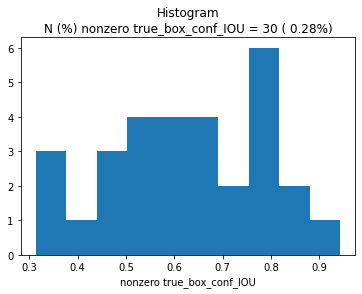

In [97]:
true_box_conf_IOU = calc_IOU_pred_true_assigned(
    true_box_conf, 
    true_box_xy, true_box_wh, 
    pred_box_xy, pred_box_wh
)
print("*"*30 + "\ninput\n" + "*"*30)    
print("true_box_conf = {}".format(true_box_conf))
print("true_box_xy   = {}".format(true_box_xy))
print("true_box_wh   = {}".format(true_box_wh))
print("pred_box_xy   = {}".format(pred_box_xy))
print("pred_box_wh   = {}".format(pred_box_wh))

print("*"*30 + "\noutput\n" + "*"*30)
print("true_box_conf_IOU.shape = {}".format(true_box_conf_IOU.shape))

vec = true_box_conf_IOU
pick  = vec != 0
vec = vec[pick]
plt.hist(vec)

plt.title("Histogram\nN (%) nonzero true_box_conf_IOU = {} ({:5.2f}%)".format(
    np.sum(pick), 100*np.mean(pick)
))

plt.xlabel("nonzero true_box_conf_IOU")
plt.show()